## Missing Value Support

author: Jacob Schreiber <br>
contact:
jmschreiber91@gmail.com

The majority of machine learning algorithms assume that they are operating on a
fully observed data set. In contast, a great deal of data sets in the real world
are missing some values. Sometimes, this missingness is missing at random (MAR),
which means that there is no important pattern to the missingness, and sometimes
the missingness itself can be interpreted as a feature. For example, in the
Titanic data set, males were more likely to have missing records than females
were, and those without children were more likely to have missing records. 

A
common approach to bridging this gap is to impute the missing values and then
treat the entire data set as observed. For continuous features this is commonly
done by replacing the missing values with the mean or median of the column. For
categorical variables it is commonly done by replacing the missing values with
the most common category observed in that column. While these techniques are
simple and allow for almost any ML algorithm to be run, they are frequently
suboptimal. Consider the follow simple example of continuous data that is
bimodally distributed:

In [1]:
%matplotlib inline
import time
import pandas
import random
import numpy
import matplotlib.pyplot as plt
import seaborn; seaborn.set_style('whitegrid')
import itertools

from pomegranate import *

random.seed(0)
numpy.random.seed(0)
numpy.set_printoptions(suppress=True)

%load_ext watermark
%watermark -m -n -p numpy,scipy,pomegranate

Fri Apr 26 2019 

numpy 1.15.4
scipy 1.2.1
pomegranate 0.10.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.4.0-17763-Microsoft
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


In [2]:
%pylab inline
from pomegranate import *
import seaborn
seaborn.set_style('whitegrid')
numpy.random.seed(0)

Populating the interactive namespace from numpy and matplotlib


/home/unpingco/.conda/envs/py37/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


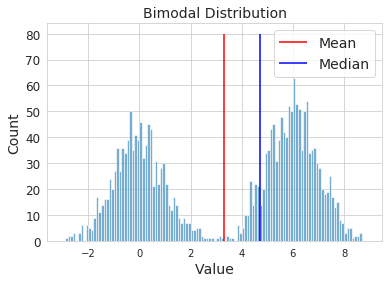

In [3]:
X = numpy.concatenate([numpy.random.normal(0, 1, size=(1000)), numpy.random.normal(6, 1, size=(1250))])

plt.title("Bimodal Distribution", fontsize=14)
plt.hist(X, bins=numpy.arange(-3, 9, 0.1), alpha=0.6)
plt.ylabel("Count", fontsize=14)
plt.yticks(fontsize=12)
plt.xlabel("Value", fontsize=14)
plt.yticks(fontsize=12)
plt.vlines(numpy.mean(X), 0, 80, color='r', label="Mean")
plt.vlines(numpy.median(X), 0, 80, color='b', label="Median")
plt.legend(fontsize=14)
plt.show()

The data peaks around 0 and around 6. Replacing the missing values with ~3 will
be inserting values into the data set that mostly don't exist in the observed
values. The median is slightly better, but will still cause the imputed values
to be in one of the two clusters. This has the effect of essentially increasing
the variance of the appropriate distribution. Let's take a look at what the
distribution looks like if we add 500 missing values and then impute them using
the mean of the observed values.

/home/unpingco/.conda/envs/py37/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


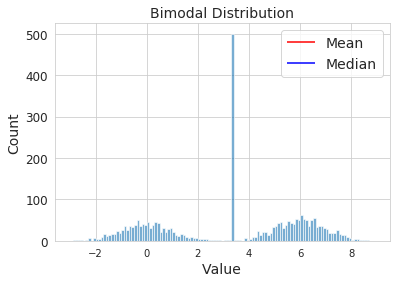

In [4]:
X = numpy.concatenate([X, [numpy.nan]*500])
X_imp = X.copy()
X_imp[numpy.isnan(X_imp)] = numpy.mean(X_imp[~numpy.isnan(X_imp)])

plt.title("Bimodal Distribution", fontsize=14)
plt.hist(X_imp, bins=numpy.arange(-3, 9, 0.1), alpha=0.6)
plt.ylabel("Count", fontsize=14)
plt.yticks(fontsize=12)
plt.xlabel("Value", fontsize=14)
plt.yticks(fontsize=12)
plt.vlines(numpy.mean(X), 0, 80, color='r', label="Mean")
plt.vlines(numpy.median(X), 0, 80, color='b', label="Median")
plt.legend(fontsize=14)
plt.show()

It doesn't appear to be that great. We can see the issue with increased variance
by trying to fit a Gaussian mixture model to the data with the imputed values,
versus fitting it to the data and ignoring missing values.

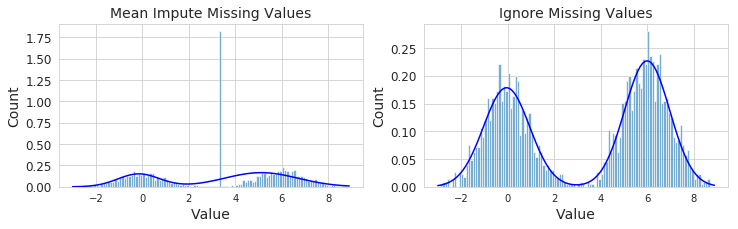

In [5]:
x = numpy.arange(-3, 9, 0.1)
model1 = GeneralMixtureModel.from_samples(NormalDistribution, 2, X_imp.reshape(X_imp.shape[0], 1))
model2 = GeneralMixtureModel.from_samples(NormalDistribution, 2, X.reshape(X.shape[0], 1))
p1 = model1.probability(x.reshape(x.shape[0], 1))
p2 = model2.probability(x.reshape(x.shape[0], 1))

plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.title("Mean Impute Missing Values", fontsize=14)
plt.hist(X_imp, bins=x, alpha=0.6, density=True)
plt.plot(x, p1, color='b')
plt.ylabel("Count", fontsize=14); plt.yticks(fontsize=12)
plt.xlabel("Value", fontsize=14); plt.yticks(fontsize=12)

plt.subplot(122)
plt.title("Ignore Missing Values", fontsize=14)
plt.hist(X[~numpy.isnan(X)], bins=x, alpha=0.6, density=True)
plt.plot(x, p2, color='b')
plt.ylabel("Count", fontsize=14); plt.yticks(fontsize=12)
plt.xlabel("Value", fontsize=14); plt.yticks(fontsize=12)
plt.show()

When we impute the missing values, it seems that one component is fit properly
and one has drastically increased variance. In contrast, when we ignore the
missing values, we fit a model that represents the underlying data much more
faithfully.

At this point, you may think that as long as the data comes from a
single distribution it shouldn't matter if you do a mean imputation of the data.
However, this has the effect of shrinking the variance inappropriately. Let's
take a look quickly at data drawn from a single Gaussian.

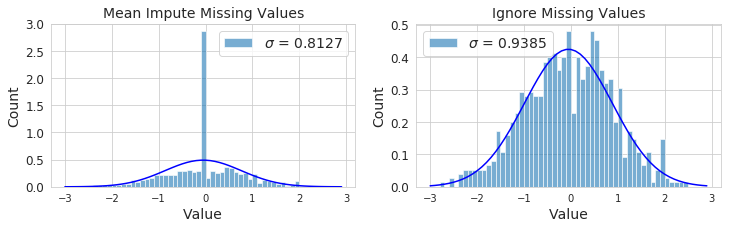

In [6]:
X = numpy.concatenate([numpy.random.normal(0, 1, size=(750)), [numpy.nan]*250])
X_imp = X.copy()
X_imp[numpy.isnan(X_imp)] = numpy.mean(X_imp[~numpy.isnan(X_imp)])

x = numpy.arange(-3, 3, 0.1)
d1 = NormalDistribution.from_samples(X_imp)
d2 = NormalDistribution.from_samples(X)
p1 = d1.probability(x.reshape(x.shape[0], 1))
p2 = d2.probability(x.reshape(x.shape[0], 1))

plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.title("Mean Impute Missing Values", fontsize=14)
plt.hist(X_imp, bins=x, alpha=0.6, density=True, label="$\sigma$ = {:4.4}".format(d1.parameters[1]))
plt.plot(x, p1, color='b')
plt.ylabel("Count", fontsize=14); plt.yticks(fontsize=12)
plt.xlabel("Value", fontsize=14); plt.yticks(fontsize=12)
plt.legend(fontsize=14)

plt.subplot(122)
plt.title("Ignore Missing Values", fontsize=14)
plt.hist(X[~numpy.isnan(X)], bins=x, alpha=0.6, density=True, label="$\sigma$ = {:4.4}".format(d2.parameters[1]))
plt.plot(x, p2, color='b')
plt.ylabel("Count", fontsize=14); plt.yticks(fontsize=12)
plt.xlabel("Value", fontsize=14); plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.show()

Even when the data is all drawn from a single, Gaussian, distribution, it is not
a great idea to do mean imputation. We can see that the standard deviation of
the learned distribution is significantly smaller than the true standard
deviation (of 1), whereas if the missing data is ignored the value is closer.

This might all be intuitive for a single variable. However, the concept of only
collecting sufficient statistics from values that are present in the data and
ignoring the missing values can be used in much more complicated, and/or
multivariate models. Let's take a look at how well one can estimate the
covariance matrix of a multivariate Gaussian distribution using these two
strategies.

In [19]:
n, d, steps = 1000, 10, 50
diffs1 = numpy.zeros(int(steps*0.86))
diffs2 = numpy.zeros(int(steps*0.86))

X = numpy.random.normal(6, 3, size=(n, d))

for k, size in enumerate(range(0, int(n*d*0.86), n*d // steps)):
    idxs = numpy.random.choice(numpy.arange(n*d), replace=False, size=size)
    i, j = idxs // d, idxs % d

    cov_true = numpy.cov(X, rowvar=False, bias=True)
    X_nan = X.copy()
    X_nan[i, j] = numpy.nan

    X_mean = X_nan.copy()
    for col in range(d):
        mask = numpy.isnan(X_mean[:,col])
        X_mean[mask, col] = X_mean[~mask, col].mean()

    diff = numpy.abs(numpy.cov(X_mean, rowvar=False, bias=True) - cov_true).sum()
    diffs1[k] = diff

    dist = MultivariateGaussianDistribution.from_samples(X_nan)
    diff = numpy.abs(numpy.array(dist.parameters[1]) - cov_true).sum()
    diffs2[k] = diff

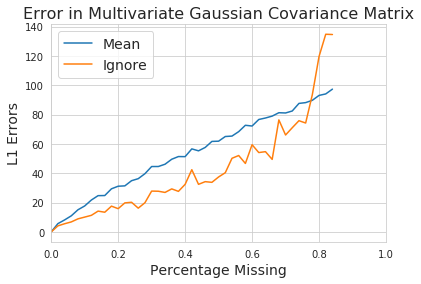

In [20]:
plt.title("Error in Multivariate Gaussian Covariance Matrix", fontsize=16)
plt.plot(diffs1, label="Mean")
plt.plot(diffs2, label="Ignore")

plt.xlabel("Percentage Missing", fontsize=14)
plt.ylabel("L1 Errors", fontsize=14)
plt.xticks(range(0, 51, 10), numpy.arange(0, 5001, 1000) / 5000.)
plt.xlim(0, 50)
plt.legend(fontsize=14)
plt.show()

In even the simplest case of Gaussian distributed data with a diagonal
covariance matrix, it is more accurate to use the ignoring strategy rather than
imputing the mean. When the data set is mostly unobserved the mean imputation
strategy tends to do better in this case, but only because there is so little
data for the ignoring strategy to actually train on. The deflation of the
variance benefits the mean imputation strategy because all of the off-diagonal
elements should be 0, but are likely to be artificially high when there are only
few examples of the pairs of the variables co-existing in the dataset. This
weakness in the ignoring strategy also makes it more likely to encounter linear
algebra errors, such as a non-invertable covariance matrix.

This long introduction is a way of saying that pomegranate uses a strategy of
ignoring missing values instead of attempting to impute them, followed by
fitting to the newly complete data set. There are other imputation strategies,
such as those based on EM, that would be a natural fit with the types of
probabilistic models implemented in pomegranate. While those have not yet been
added, they would be a good addition that I hope to get to this year.

Let's now
take a look at how to use missing values in some pomegranate models!

### 1. Distributions

We've seen some examples of fitting distributions to
missing data. For univariate distributions, the missing values are simply
ignored when fitting to the data.

In [21]:
X = numpy.random.randn(100)
X_nan = numpy.concatenate([X, [numpy.nan]*100])

print( "Fitting only to observed values:")
print( NormalDistribution.from_samples(X))
print( "Fitting to observed and missing values:")
print( NormalDistribution.from_samples(X_nan))

Fitting only to observed values:
{
    "class" :"Distribution",
    "name" :"NormalDistribution",
    "parameters" :[
        -0.015863970246564402,
        0.9524657558458957
    ],
    "frozen" :false
}
Fitting to observed and missing values:
{
    "class" :"Distribution",
    "name" :"NormalDistribution",
    "parameters" :[
        -0.015863970246564402,
        0.9524657558458957
    ],
    "frozen" :false
}


This may seem to be an obvious thing to do. However, it suggests a way for
dealing with multivariate data being modeled with an
IndependentComponentsDistribution when some of the features are missing.
Specifically, treat each column independently, and update based on the observed
values, regardless of if there is an unobserved value in the same sample but
another column. For example:

In [22]:
X = numpy.random.normal(0, 1, size=(500, 3))
idxs = numpy.random.choice(1500, replace=False, size=500)
i, j = idxs // 3, idxs % 3
X[i, j] = numpy.nan

d = IndependentComponentsDistribution.from_samples(X, distributions=[NormalDistribution]*3)
d

{
    "class" : "Distribution",
    "name" : "IndependentComponentsDistribution",
    "parameters" : [
        [
            {
                "class" : "Distribution",
                "name" : "NormalDistribution",
                "parameters" : [
                    0.03878314897968443,
                    0.933317463850734
                ],
                "frozen" : false
            },
            {
                "class" : "Distribution",
                "name" : "NormalDistribution",
                "parameters" : [
                    0.03194388683982548,
                    1.053954262701933
                ],
                "frozen" : false
            },
            {
                "class" : "Distribution",
                "name" : "NormalDistribution",
                "parameters" : [
                    -0.09977255236868,
                    0.9961656946307669
                ],
                "frozen" : false
            }
        ],
        [
            1.0,
     

Easy. As we saw above, we can do the same to learn a multivariate Gaussian
distribution in the presence of missing data. Again, we don't need to change
anything about how we interact with the data, and there are no flags to toggle.
The last aspect is that the probability of missing data under any univariate
distribution is 1, for the purposes of downstream algorithms.

In [23]:
NormalDistribution(1, 2).probability(numpy.nan)

1.0

In an IndependentComponentsDistribution, this just means that when multiplying
together the probabilities of each feature to get the total probability, that
some dimensions don't factor into the calculation.

In [24]:
d.probability((numpy.nan, 2, 3))

0.00020938157586346132

In [25]:
d.distributions[1].probability(2) * d.distributions[2].probability(3)

0.0002093815758634614

### 2. K-Means Clustering

K-means clustering mostly serves a helper role in
initializing mixture models and hidden Markov models. However, it can still be
used by itself if desired. In addition to having the same parallelization and
out-of-core capabilities of the main models, it also supports missing values
now.

In [26]:
X = numpy.concatenate([numpy.random.normal(0, 1, size=(50, 2)), numpy.random.normal(3, 1, size=(75, 2))])
X_nan = X.copy()

idxs = numpy.random.choice(250, replace=False, size=50)
i, j = idxs // 2, idxs % 2
X_nan[i, j] = numpy.nan

Just like the other models, you don't need to change the method calls in order
to handle missing data. You can fit a K-means model to data sets with missing
values and make predictions on samples with missing values in the same way you
would without missing values. The prediction step will assign samples to the
nearest centroid in the dimensions that are observed, ignoring the missing
values.

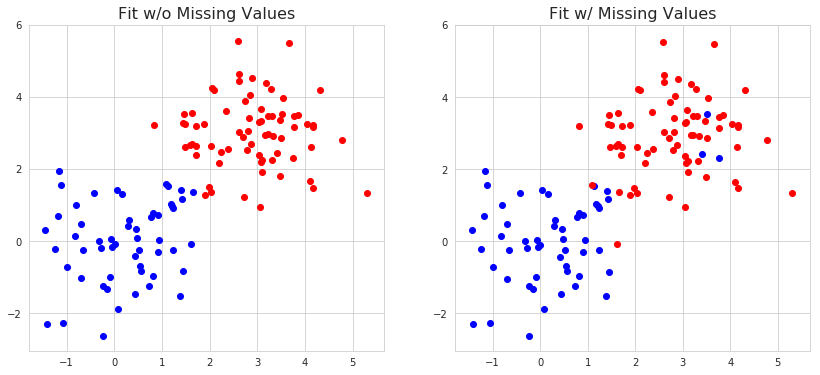

In [27]:
model1 = Kmeans.from_samples(2, X)
model2 = Kmeans.from_samples(2, X_nan)

y1 = model1.predict(X)
y2 = model2.predict(X_nan)

plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.title("Fit w/o Missing Values", fontsize=16)
plt.scatter(X[y1 == 0,0], X[y1 == 0,1], color='b')
plt.scatter(X[y1 == 1,0], X[y1 == 1,1], color='r')

plt.subplot(122)
plt.title("Fit w/ Missing Values", fontsize=16)
plt.scatter(X[y2 == 0,0], X[y2 == 0,1], color='b')
plt.scatter(X[y2 == 1,0], X[y2 == 1,1], color='r')
plt.show()

We can see that there are some blue points in the red cluster on the right plot
because those samples are entirely NaN. Any sample that is entirely NaN is
assigned to cluster 0. Otherwise, it's still able to identify the two clusters
even there there are many missing values.

### 3. General Mixture Models

Missing value support for mixture models follows
that of k-means fairly closely. Essentially, one passes in a data set containing
missing values denoted as `numpy.nan` and they get used appropriately for the
fit and predict steps. All methods automatically handle missing values
appropriately without any additional flags or methods. 

Since training is an
iterative procedure that involves calculating the probabilities of samples given
each component, multivariate Gaussian mixtures will be much slower when handling
missing values than they would be when using only observed values. This is
because an inverse covariance matrix has to be calculated by subsetting the
covariance matrix and inverting it based only on the observed dimensions for
each sample. Each sample, then, needs its own matrix inversion. Since there is
no single inverse covariance matrix, one also cannot use BLAS or a GPU to
accelerate this step.

In [28]:
X = numpy.concatenate([numpy.random.normal(0, 1, size=(1000, 10)), numpy.random.normal(2, 1, size=(1250, 10))])

idxs = numpy.random.choice(22500, replace=False, size=5000)
i, j = idxs // 10, idxs % 10

X_nan = X.copy()
X_nan[i, j] = numpy.nan

%timeit GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, 2, X, max_iterations=10)
%timeit GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, 2, X_nan, max_iterations=10)

5.02 ms ± 198 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.14 s ± 1.64 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


However, if one was modeling each dimension independently, there should be no
hit at all!

In [29]:
%timeit -n 100 GeneralMixtureModel.from_samples([NormalDistribution]*2, 2, X, max_iterations=10)
%timeit -n 100 GeneralMixtureModel.from_samples([NormalDistribution]*2, 2, X_nan, max_iterations=10)

5.25 ms ± 299 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.76 ms ± 103 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### 4. Naive Bayes / Bayes Classifiers

Support for these models mirrors what's been seen before. However, since the
fitting step does not involve calculating probabilities of samples, it should be
no slower to train them on data sets involving missing values than to train them
on dense data sets.

In [30]:
y = numpy.concatenate([numpy.zeros(1000), numpy.ones(1250)])

%timeit -n 100 BayesClassifier.from_samples(MultivariateGaussianDistribution, X, y)
%timeit -n 100 BayesClassifier.from_samples(MultivariateGaussianDistribution, X_nan, y)

1.02 ms ± 173 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.42 ms ± 25.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Since pomegranate also has semi-supervised learning built-in, this means that
one can now fit Bayes classifiers on data sets with missingness in both the
labels and in the values! Since semi-supervised learning does rely on EM, it
will be slower to train multivariate Gaussian models with missing values than
not to.

In [31]:
idx = numpy.random.choice(2250, replace=False, size=750)
y_nan = y.copy()
y_nan[idx] = -1

model = BayesClassifier.from_samples(MultivariateGaussianDistribution, X_nan, y_nan, verbose=True)

[1] Improvement: 53.094087806262905	Time (s): 0.1756
[2] Improvement: 0.34943396540984395	Time (s): 0.1639
[3] Improvement: 0.030924540053092642	Time (s): 0.1774
Total Improvement: 53.47444631172584
Total Time (s): 0.6918


In [32]:
%timeit BayesClassifier.from_samples(MultivariateGaussianDistribution, X, y_nan)
%timeit BayesClassifier.from_samples(MultivariateGaussianDistribution, X_nan, y_nan)

4.34 ms ± 107 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
670 ms ± 9.89 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 5. Hidden Markov Models

Hidden Markov models are slightly different from
the others, in that they operate over sequences. This adds another level of
complication to the model because the forward and backward algorithms are needed
in order to identify the best component for each observation. Typically this
involves calculating the probability of each observation given each state, and
taking the sum of all paths through the model, multiplying the transition
probability of each edge crossed by the emission probability of the state you
transition to emitting the next character. If this is a univariate model and the
character is missing, you ignore the emission probability and just multiply by
the transition probability. This is easily done by having the probability of
missing values be 1 under all univariate models.

In [33]:
d1 = DiscreteDistribution({'A': 0.25, 'B': 0.75})
d2 = DiscreteDistribution({'A': 0.67, 'B': 0.33})

s1 = State(d1, name="s1")
s2 = State(d2, name="s2")

model = HiddenMarkovModel()
model.add_states(s1, s2)
model.add_transition(model.start, s1, 1.0)
model.add_transition(s1, s1, 0.5)
model.add_transition(s1, s2, 0.5)
model.add_transition(s2, s2, 0.5)
model.add_transition(s2, s1, 0.5)
model.bake()

Now let's run the forward algorithm on a simple sequence.

In [34]:
numpy.exp(model.forward(['A', 'B', 'A', 'A']))

array([[0.       , 0.       , 1.       , 0.       ],
       [0.25     , 0.       , 0.       , 0.       ],
       [0.09375  , 0.04125  , 0.       , 0.       ],
       [0.016875 , 0.045225 , 0.       , 0.       ],
       [0.0077625, 0.0208035, 0.       , 0.       ]])

Let's see what happens when we remove one of the characters.

In [35]:
numpy.exp(model.forward(['A', 'nan', 'A', 'A']))

array([[0.      , 0.      , 1.      , 0.      ],
       [0.25    , 0.      , 0.      , 0.      ],
       [0.125   , 0.125   , 0.      , 0.      ],
       [0.03125 , 0.08375 , 0.      , 0.      ],
       [0.014375, 0.038525, 0.      , 0.      ]])

We can see that initially the first character is aligned to s1 because there is
a 100% chance of going from the start state to s1. The value is 0.25 because it
is equal to the transition probability (1.0) multiplied by the emission
probability (0.25). In the next step, you can see that the probability is
equally diffused between two options, staying in the current state (transition
probability of 0.5) and moving to s2 (also transition probability of 0.5). Since
the character is missing, there is no emission probability to multiply by. 

If
we want to decode the sequence we can call the same methods as before.

In [36]:
model.predict(['A', 'A', 'B', 'B', 'A', 'A'])

[0, 1, 0, 0, 1, 1]

In [37]:
model.predict(['A', 'nan', 'B', 'B', 'nan', 'A'])

[0, 0, 0, 0, 0, 1]

Fitting is pretty much the same story as the previous models. Like the Bayes
classifiers, one can now train a hidden Markov model in a supervised manner,
having some observations in the sequence missing, but also labels on each
observation. Labeled missing data can still be used to train the transition
parameters.

### 6. Bayesian Networks

Bayesian networks could previously handle missing data
in the `predict` and `predict_proba` methods. In fact, handling missing data was
the area in which they excelled. However, one couldn't calculate the probability
of a sample containing missing values, fit a Bayesian network to incomplete data
sets, or learn the structure of a network on incomplete data sets. The new
missing value support allows all of these things (except Chow-Liu tree building
on missing data sets)! To be clear, there is a very common iterative technique
for fitting/learning models on incomplete data sets using an iterative EM based
approach. This does not do that. This only ignores sufficient statistics from
missing samples, and so is not an iterative approach.

Learning the structure of
a network on an incomplete data set should take a similar amount of time as
learning it on a complete data set. If you are indicating missing values in
numeric data sets, you will have to convert your data set to floats, whereas
previously integers would be fine. If your data set is complete, there is no
need.

In [38]:
X = numpy.random.randint(3, size=(500, 10)).astype('float64')

idxs = numpy.random.choice(5000, replace=False, size=2000)
i, j = idxs // 10, idxs % 10
X_nan = X.copy()
X_nan[i, j] = numpy.nan

%timeit -n 100 BayesianNetwork.from_samples(X, algorithm='exact')
%timeit -n 100 BayesianNetwork.from_samples(X_nan, algorithm='exact')

107 ms ± 938 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
139 ms ± 2.45 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Conclusions

Missing value support has been added to pomegranate as of
v0.9.0! A lot of care was taken to make the interface as simple to the end user
while not compromising on speed. While multivariate Gaussian distributions, and
the compositional models that are built on top of them, may be slower on
incomplete data sets than on complete ones, everything else should take a
similar amount of time!

The implemented missing value support focuses on
ignoring data that is missing. Another approach that works well is to use an EM
based algorithm to impute the missing values based on the observed values and
the model and fit to that complete data set. This works well in the framework of
probabilistic modeling and is a natural addition to pomegranate that I hope to
add in the coming year.

As always, feedback and questions are always welcome!